<a href="https://colab.research.google.com/github/nischay-32/Object-Detection-using-TensorFlow/blob/main/Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Object Detection [Classification + Localization]

## 1: Installing and Importing Libraries

In [1]:
! pip install tensorflow
! pip install tensorflow-datasets
! pip install Pillow
! pip install pandas

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image, ImageDraw, ImageFont

# --- Constants ---
IMAGE_WIDTH = 75
IMAGE_HEIGHT = 75
USE_NORMALIZED_COORDINATES = True

print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.19.0


## 2.Visualiozation Utilities

In [19]:
def draw_bounding_boxes_on_image_array(image_array, boxes, colors, thickness=4, display_str_list=()):
    """Draws bounding boxes on an image array."""
    # Convert image from 0-1 float to 0-255 uint8 for drawing
    image_pil = Image.fromarray(np.uint8(image_array * 255)).convert("RGB")
    draw = ImageDraw.Draw(image_pil)
    im_width, im_height = image_pil.size

    for i in range(boxes.shape[0]):
        if USE_NORMALIZED_COORDINATES:
            (left, right, top, bottom) = (
                boxes[i][0] * im_width,
                boxes[i][1] * im_width,
                boxes[i][2] * im_height,
                boxes[i][3] * im_height,
            )
        else:
            (left, right, top, bottom) = (boxes[i][0], boxes[i][1], boxes[i][2], boxes[i][3])

        draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)], width=thickness, fill=colors[i])

        display_str = ""
        if i < len(display_str_list):
            display_str = display_str_list[i]

        if display_str:
            try:
                font = ImageFont.truetype("arial.ttf", 20)
            except IOError:
                font = ImageFont.load_default()

            left_text, top_text, right_text, bottom_text = font.getbbox(display_str)
            text_width = right_text - left_text
            text_height = bottom_text - top_text
            margin = np.ceil(0.05 * text_height)
            draw.rectangle([(left, bottom - text_height - 2 * margin), (left + text_width, bottom)], fill=colors[i])
            draw.text((left + margin, bottom - text_height - margin), display_str, fill="black", font=font)

    return np.array(image_pil) / 255.0

def dataset_to_numpy_util(training_dataset, validation_dataset, N):
    """Converts TensorFlow datasets to NumPy arrays."""
    # --- CORRECTED PART ---
    # Unpack the nested labels (label, bbox) correctly
    training_images = np.array([image.numpy() for image, _ in training_dataset.take(N)])
    training_labels = np.array([labels[0].numpy() for _, labels in training_dataset.take(N)])
    training_bboxes = np.array([labels[1].numpy() for _, labels in training_dataset.take(N)])

    validation_images = np.array([image.numpy() for image, _ in validation_dataset.take(N)])
    validation_labels = np.array([labels[0].numpy() for _, labels in validation_dataset.take(N)])
    validation_bboxes = np.array([labels[1].numpy() for _, labels in validation_dataset.take(N)])
    # --- END CORRECTION ---

    return (training_images, training_labels, training_bboxes, validation_images, validation_labels, validation_bboxes)

def display_digits_with_boxes(digits, predictions, pred_bboxes, true_labels, true_bboxes, title):
    """Displays digits with predicted bounding boxes."""
    n = 10
    indexes = np.random.choice(len(predictions), size=n)

    plt.figure(figsize=(20, 4))
    plt.suptitle(title, fontsize=16)

    for i, index in enumerate(indexes):
        ax = plt.subplot(1, n, i + 1)

        pred_label = np.argmax(predictions[index])
        pred_bbox = pred_bboxes[index]
        true_label = true_labels[index]

        color = "green" if pred_label == true_label else "red"

        image_with_box = draw_bounding_boxes_on_image_array(digits[index], np.array([pred_bbox]), [color])
        plt.imshow(image_with_box)
        plt.xticks([])
        plt.yticks([])
        ax.set_xlabel(f"Pred: {pred_label}", color=color)
        ax.set_ylabel(f"True: {true_label}", color="black")

    plt.show()

## 3. Loading and Preprocessing the dataset

##

In [20]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize and add a channel dimension
x_train = np.expand_dims(x_train.astype("float32") / 255.0, axis=-1)
x_test = np.expand_dims(x_test.astype("float32") / 255.0, axis=-1)

def create_synthetic_example(digit_image, digit_label):
    """Creates a larger canvas and places a digit randomly on it."""
    canvas = np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype="float32")
    digit_h, digit_w, _ = digit_image.shape

    max_y = IMAGE_HEIGHT - digit_h
    max_x = IMAGE_WIDTH - digit_w
    start_y = np.random.randint(0, max_y)
    start_x = np.random.randint(0, max_x)

    canvas[start_y:start_y + digit_h, start_x:start_x + digit_w, :] = digit_image

    x_min = start_x / IMAGE_WIDTH
    x_max = (start_x + digit_w) / IMAGE_WIDTH
    y_min = start_y / IMAGE_HEIGHT
    y_max = (start_y + digit_h) / IMAGE_HEIGHT
    bbox = np.array([x_min, x_max, y_min, y_max], dtype="float32")

    canvas_rgb = np.repeat(canvas, 3, axis=-1)
    # --- CORRECTED PART ---
    # Return the image and a TUPLE of the two labels
    return canvas_rgb, (digit_label, bbox)

def synthetic_data_generator(images, labels):
    """Yields synthetic images and their corresponding labels and bboxes."""
    for i in range(len(images)):
        # The create_synthetic_example function now returns the correct structure
        yield create_synthetic_example(images[i], labels[i])

# --- CORRECTED PART ---
# The output_signature now reflects the nested tuple structure for the labels
output_signature = (
    tf.TensorSpec(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), dtype=tf.float32),
    (
        tf.TensorSpec(shape=(), dtype=tf.int64),
        tf.TensorSpec(shape=(4,), dtype=tf.float32)
    )
)

training_dataset = tf.data.Dataset.from_generator(
    lambda: synthetic_data_generator(x_train, y_train), output_signature=output_signature
)
validation_dataset = tf.data.Dataset.from_generator(
    lambda: synthetic_data_generator(x_test, y_test), output_signature=output_signature
)

print("✅ Synthetic datasets created successfully with the correct structure.")

✅ Synthetic datasets created successfully with the correct structure.


In [21]:
# Define the augmentation layers
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomRotation(0.1),
  tf.keras.layers.RandomZoom(0.1),
  tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
  tf.keras.layers.RandomContrast(0.1),
], name="data_augmentation")

def build_model():
    """Builds a deep model with data augmentation."""
    inputs = tf.keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    x = data_augmentation(inputs)

    # Feature Extractor
    x = tf.keras.layers.Conv2D(32, kernel_size=3, activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(64, kernel_size=3, activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(64, kernel_size=3, activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Flatten()(x)

    # Dense layers
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    # Heads
    classification_head = tf.keras.layers.Dense(10, activation="softmax", name="classification_head")(x)
    bbox_head = tf.keras.layers.Dense(4, name="bounding_box_head")(x)

    model = tf.keras.Model(inputs=inputs, outputs=[classification_head, bbox_head])
    return model

# Build the model
model = build_model()

# Compile with a smaller learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(
    optimizer=optimizer,
    loss={"classification_head": "sparse_categorical_crossentropy", "bounding_box_head": "mse"},
    metrics={"classification_head": "accuracy", "bounding_box_head": "mae"},
)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 75, 75, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 75, 75, 3) │          0 │ input_layer_2[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 73, 73,    │        896 │ data_augmentatio… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 36, 36,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 34, 34,    │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 17, 17,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 15, 15,    │     36,928 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 7, 7, 64)  │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 3136)      │          0 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │    401,536 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classification_head │ (None, 10)        │      1,290 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bounding_box_head   │ (None, 4)         │        516 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 459,662 (1.75 MB)

 Trainable params: 459,662 (1.75 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Prepare the datasets for training
BATCH_SIZE = 64
EPOCHS = 30  # Increased for better accuracy

train_ds = training_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = validation_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Train the model
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

Epoch 1/30
    938/Unknown 42s 36ms/step - bounding_box_head_loss: 0.0588 - bounding_box_head_mae: 0.1813 - classification_head_accuracy: 0.1427 - classification_head_loss: 2.2639 - loss: 2.3227

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


938/938 ━━━━━━━━━━━━━━━━━━━━ 47s 42ms/step - bounding_box_head_loss: 0.0588 - bounding_box_head_mae: 0.1813 - classification_head_accuracy: 0.1428 - classification_head_loss: 2.2638 - loss: 2.3226 - val_bounding_box_head_loss: 0.0147 - val_bounding_box_head_mae: 0.0917 - val_classification_head_accuracy: 0.3348 - val_classification_head_loss: 1.8436 - val_loss: 1.8706
Epoch 2/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 40s 43ms/step - bounding_box_head_loss: 0.0648 - bounding_box_head_mae: 0.1971 - classification_head_accuracy: 0.3768 - classification_head_loss: 1.7677 - loss: 1.8325 - val_bounding_box_head_loss: 0.0132 - val_bounding_box_head_mae: 0.0896 - val_classification_head_accuracy: 0.7440 - val_classification_head_loss: 0.8590 - val_loss: 0.8792
Epoch 3/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 39s 41ms/step - bounding_box_head_loss: 0.0568 - bounding_box_head_mae: 0.1847 - classification_head_accuracy: 0.6250 - classification_head_loss: 1.1483 - loss: 1.2052 - val_bounding_box_head_loss: 0.0152 - 

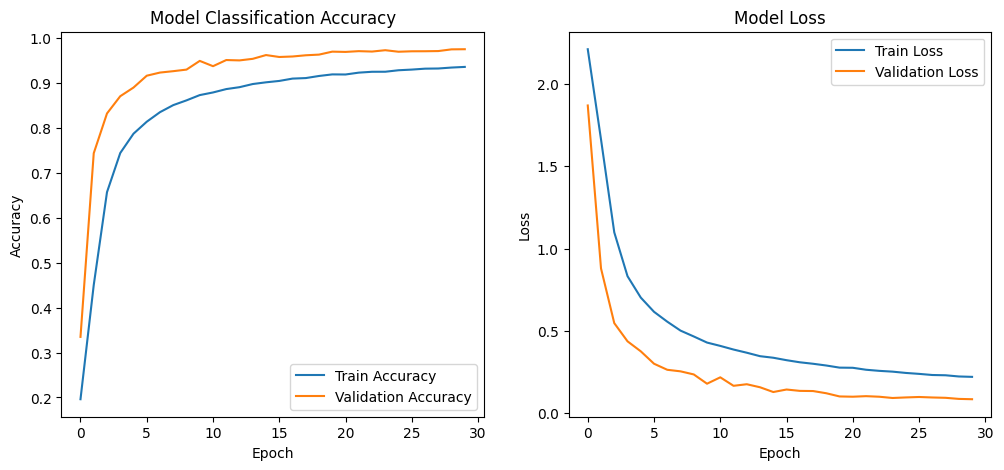

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


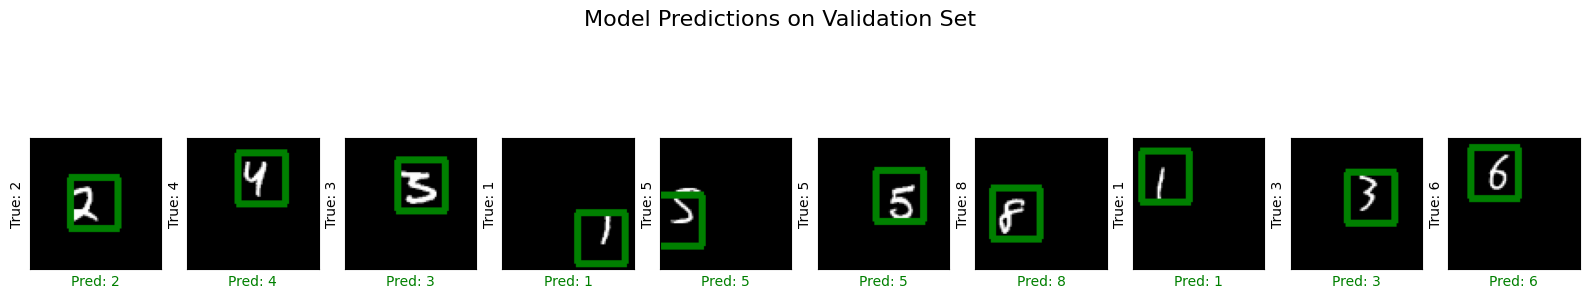

In [23]:
# Plot the training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['classification_head_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_classification_head_accuracy'], label='Validation Accuracy')
plt.title('Model Classification Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Make predictions on the validation set
(
    _, _, _,
    validation_digits,
    validation_labels,
    validation_bboxes
) = dataset_to_numpy_util(training_dataset, validation_dataset, N=500) # Use a larger sample for visualization

predictions = model.predict(validation_digits)
pred_labels = predictions[0]
pred_bboxes = predictions[1]

# Visualize the predictions
display_digits_with_boxes(
    validation_digits,
    pred_labels,
    pred_bboxes,
    validation_labels,
    validation_bboxes,
    "Model Predictions on Validation Set",
)